In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from tools import *
from trainers import *
from datasets import *

params = {}
params['input_dim_a'] = 3
params['input_dim_b'] = 3
params['ch'] = 64
params['n_enc_front_blk'] = 3
params['n_enc_res_blk'] = 3
params['n_enc_shared_blk'] = 1
params['n_gen_shared_blk'] = 1
params['n_gen_res_blk'] = 3
params['n_gen_front_blk'] = 3

g = COCOResGen(params)
g = g.cuda()
X = Variable(torch.FloatTensor(np.random.rand(3, 256, 256).reshape(1, 3, 256, 256))).cuda()
Y = Variable(torch.FloatTensor(np.random.rand(3, 256, 256).reshape(1, 3, 256, 256))).cuda()

ImportError: cannot import name 'izip'

In [2]:
torch.cuda.is_available()

True

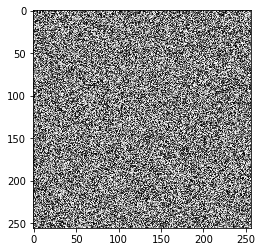

torch.Size([1, 3, 256, 256])


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X.data[0, 0, :, :], cmap='gray')
plt.show()
print(X.shape)

In [4]:
x_xx, x_yx, x_xy, x_yy, shared = g(X, Y)
print(x_xx.size())
print(x_yx.size())
print(x_xy.size())
print(x_yy.size())
print(shared.size())

#min image size is (2^(n_enc_front_blk-1))
#i =  image size / (2^(n_enc_front_blk-1)), j = ch*(2^(n_enc_front_blk-1)), shared is 2xjxixi (if coming from both encoder, batchxjxixi if from 1 encoder)
#change input in forward to be existing thing with image noise concatted to channel axis

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([2, 256, 64, 64])


In [5]:
#x_xy, shared = g.forward_a2b(X)
#print(x_xy.size())
#print(shared.size())


In [6]:
dis_params = {}
dis_params['ch'] = 64
dis_params['input_dim_a'] = 3
dis_params['input_dim_b'] = 3
dis_params['n_layer'] = 1
dis_params['n_enc_front_blk'] = 3 #need this one for the math



kl_dis = COCOKLDis(dis_params)
kl_dis.cuda(0)
print(kl_dis)

COCOKLDis(
  (img_model): Sequential(
    (0): LeakyReLUConv2d(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(0.01, inplace)
      )
    )
    (1): LeakyReLUConv2d(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(0.01, inplace)
      )
    )
    (2): LeakyReLUConv2d(
      (model): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(0.01, inplace)
      )
    )
    (3): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (noise_model): Sequential(
    (0): LeakyReLUConv2d(
      (model): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(0.01, inplace)
      )
    )
    (1): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (out): Sequential(
    (0): LeakyReLUConv2d(
      (model): Seque

In [7]:
#changed all izips to zips for python3, but classes won't load in python2 TODO check on this???

In [8]:
kl_dis_opt = torch.optim.Adam(kl_dis.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=0.0001)

images_a = X
images_b = Y

#_, _, _, _, shared = g(X, Y)

x_ab, shared_a = g.forward_a2b(images_a)
x_ba, shared_b = g.forward_b2a(images_a)

outs_a = kl_dis(X, shared_a)
outs_b = kl_dis(Y, shared_b)
prior_b = Variable(torch.randn(shared_a.size()).cuda(shared_a.data.get_device()))
prior_a = Variable(torch.randn(shared_b.size()).cuda(shared_b.data.get_device()))
outs_za = kl_dis(X, prior_b)
outs_zb = kl_dis(X, prior_a)

for it, (out_a, out_b, out_za, out_zb) in enumerate(zip(outs_a, outs_b, outs_za, outs_zb)):
  out_a = nn.functional.sigmoid(out_a)
  out_b = nn.functional.sigmoid(out_b)
  out_za = nn.functional.sigmoid(out_za)
  out_zb = nn.functional.sigmoid(out_zb)
    
  all_ones = Variable(torch.ones((out_a.size(0))).cuda(0))
  all_zeros = Variable(torch.zeros((out_a.size(0))).cuda(0))  
    
  if it==0:
    ad_loss_a = nn.functional.binary_cross_entropy(out_a, all_ones) + nn.functional.binary_cross_entropy(out_za, all_zeros)
    ad_loss_b = nn.functional.binary_cross_entropy(out_b, all_ones) + nn.functional.binary_cross_entropy(out_zb, all_zeros)
  else:
    ad_loss_a += nn.functional.binary_cross_entropy(out_a, all_ones) + nn.functional.binary_cross_entropy(out_za, all_zeros)
    ad_loss_b += nn.functional.binary_cross_entropy(out_b, all_ones) + nn.functional.binary_cross_entropy(out_zb, all_zeros)

total_loss = ad_loss_a + ad_loss_b #minus because opt minimizes rather than maximizes
total_loss.backward()
kl_dis_opt.step()
kl_dis_loss = total_loss.data.cpu().numpy()[0]
print(kl_dis_loss)

2.8691077


In [9]:
#test out the generator loss function next TODO

In [10]:
dis_params2 = {}
dis_params2['ch'] = 64
dis_params2['input_dim_a'] = 3
dis_params2['input_dim_b'] = 3
dis_params2['n_layer'] = 3

dis = COCODis(dis_params2)
dis.cuda(0)
gen_opt = torch.optim.Adam(g.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=0.0001)

In [11]:
hyperparameters = {}
hyperparameters['gan_w'] = 0.2
hyperparameters['ll_direct_link_w'] = 0.2
hyperparameters['ll_cycle_link_w'] = 0.2
hyperparameters['kl_direct_link_w'] = 0.2
hyperparameters['kl_cycle_link_w'] = 0.2

In [12]:
g.zero_grad()
ll_loss_criterion_a = torch.nn.L1Loss()
ll_loss_criterion_b = torch.nn.L1Loss()
#TODO add noise into self.gen(...
x_aa, x_ba, x_ab, x_bb, shared = g(X, Y)
x_bab, shared_bab = g.forward_a2b(x_ba)
x_aba, shared_aba = g.forward_b2a(x_ab)
outs_a, outs_b = dis(x_ba,x_ab)
for it, (out_a, out_b) in enumerate(zip(outs_a, outs_b)):
  outputs_a = nn.functional.sigmoid(out_a)
  outputs_b = nn.functional.sigmoid(out_b)
  all_ones = Variable(torch.ones((outputs_a.size(0))).cuda(0))
  if it==0:
    ad_loss_a = nn.functional.binary_cross_entropy(outputs_a, all_ones)
    ad_loss_b = nn.functional.binary_cross_entropy(outputs_b, all_ones)
  else:
    ad_loss_a += nn.functional.binary_cross_entropy(outputs_a, all_ones)
    ad_loss_b += nn.functional.binary_cross_entropy(outputs_b, all_ones)

#enc_loss  = self._compute_kl(shared)
#enc_bab_loss = self._compute_kl(shared_bab)
#enc_aba_loss = self._compute_kl(shared_aba)

_, shared_a = g.forward_a2b(X)
_, shared_b = g.forward_b2a(Y) 

outs_a = kl_dis(images_a, shared_a)
outs_b = kl_dis(images_b, shared_b)
outs_bab = kl_dis(x_ba, shared_bab)
outs_aba = kl_dis(x_ab, shared_aba)

for it, (out_a, out_b, out_bab, out_aba) in enumerate(zip(outs_a, outs_b, outs_bab, outs_aba)):
  all_zeros = Variable(torch.zeros((out_a.size(0))).cuda(0))
  out_a = nn.functional.sigmoid(out_a)
  out_b = nn.functional.sigmoid(out_b)
  out_bab = nn.functional.sigmoid(out_bab)
  out_aba = nn.functional.sigmoid(out_aba)

  if it==0:
    enc_a_loss = nn.functional.binary_cross_entropy(out_a, all_zeros)
    enc_b_loss = nn.functional.binary_cross_entropy(out_b, all_zeros)
    enc_bab_loss = nn.functional.binary_cross_entropy(out_bab, all_zeros)
    enc_aba_loss = nn.functional.binary_cross_entropy(out_aba, all_zeros)
  else:
    enc_a_loss += nn.functional.binary_cross_entropy(out_a, all_zeros)
    enc_b_loss += nn.functional.binary_cross_entropy(out_b, all_zeros)
    enc_bab_loss += nn.functional.binary_cross_entropy(out_bab, all_zeros)
    enc_aba_loss += nn.functional.binary_cross_entropy(out_aba, all_zeros)

enc_loss = enc_a_loss + enc_b_loss

ll_loss_a = ll_loss_criterion_a(x_aa, images_a)
ll_loss_b = ll_loss_criterion_b(x_bb, images_b)
ll_loss_aba = ll_loss_criterion_a(x_aba, images_a)
ll_loss_bab = ll_loss_criterion_b(x_bab, images_b)
total_loss = hyperparameters['gan_w'] * (ad_loss_a + ad_loss_b) + \
             hyperparameters['ll_direct_link_w'] * (ll_loss_a + ll_loss_b) + \
             hyperparameters['ll_cycle_link_w'] * (ll_loss_aba + ll_loss_bab) + \
        hyperparameters['kl_direct_link_w'] * (enc_loss + enc_loss) + \
             hyperparameters['kl_cycle_link_w'] * (enc_bab_loss + enc_aba_loss) #may only want one of enc_loss TODO test
total_loss.backward()
gen_opt.step()

In [13]:
print(total_loss)

Variable containing:
 1.8699
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [1]:
from trainers.helpers import get_model_version

In [4]:
from tools import NetConfig
from common import get_data_loader
from trainers import *

config = NetConfig('../exps/unit/blondhair_test4.yaml')

batch_size = config.hyperparameters['batch_size']
max_iterations = config.hyperparameters['max_iterations']

train_loader_a = get_data_loader(config.datasets['train_a'], batch_size)
train_loader_b = get_data_loader(config.datasets['train_b'], batch_size)

cmd = "trainer=%s(config.hyperparameters)" % config.hyperparameters['trainer']
local_dict = locals()
exec(cmd,globals(),local_dict)
trainer = local_dict['trainer']

# Check if resume training
version = 0
iterations = trainer.load(config.snapshot_prefix, version)
    
trainer.cuda(0)

self.image_display_iterations=100
self.image_save_iterations=2500
self.snapshot_save_iterations=5000
self.snapshot_prefix='../outputs/unit/celeba/blondhair4/blondhair4'
self.hyperparameters={'trainer': 'COCOGANTrainer', 'kl_cycle_link_w': 0.1, 'gan_w': 10, 'll_cycle_link_w': 100, 'batch_size': 1, 'll_direct_link_w': 100, 'lr': 0.0001, 'kldis': {'ch': 64, 'name': 'COCOKLDis', 'n_layer': 1, 'n_enc_front_blk': 3, 'input_dim_a': 3, 'input_dim_b': 3}, 'kl_direct_link_w': 0.1, 'max_iterations': 50000, 'gen': {'ch': 64, 'name': 'COCOResGen2', 'n_gen_front_blk': 3, 'n_enc_front_blk': 3, 'input_dim_a': 3, 'n_enc_shared_blk': 1, 'input_dim_b': 3, 'n_gen_res_blk': 3, 'n_enc_res_blk': 3, 'n_gen_shared_blk': 1}, 'dis': {'ch': 64, 'input_dim_a': 3, 'name': 'COCOMsDis', 'input_dim_b': 3, 'n_layer': 3}}
self.datasets={'train_a': {'channels': 3, 'scale': 1.0, 'class_name': 'dataset_celeba', 'folder': 'img_align_crop_resize_celeba/', 'crop_image_size': 128, 'root': '../datasets/celeba/', 'list_name': 'l

In [10]:
from datasets import dataset_celeba

dataset_a2b = config.datasets['train_a']
dataset_b2a = config.datasets['train_b']
data_a2b = []
data_b2a = []
exec ("data_a2b = %s(dataset_a2b)" % dataset_a2b['class_name'])
exec ("data_b2a = %s(dataset_b2a)" % dataset_b2a['class_name'])
